The objectives of this first lab session are the following:
- Familiarize yourself with pytorch
- Train a model from scratch using a state of the art architecture
- Learn how to load your saved models
- Explore hyperparameters of a given architecture

We will perform all experiments on the CIFAR10 dataset. 

## Part 1

Familiarize yourself with pytorch by doing the [Pytorch_tutorial.ipynb](Pytorch_tutorial.ipynb), a jupyter notebook that you will be able to run also in VScode, after installing the Jupyter extension (remember to "Trust" the notebook, as explained [here](https://code.visualstudio.com/docs/python/jupyter-support)). If you are familiar with pytorch, you can go quickly over the tutorial and try to train a classifier in section 4 where you are asked to complete some cells.


## Part 2 

The following code can be used to obtain a DataLoader for CIFAR10, ready for training in pytorch : 

see https://github.com/kuangliu/pytorch-cifar/tree/master/models

In [1]:
from datetime import datetime
import numpy as np 
from matplotlib.pylab import plt
import gc
import polars as pl
import time

import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from models_cifar100 import *

In [2]:
device = torch.device('cuda:0')

In [3]:
## Normalization adapted for CIFAR10
normalize_scratch = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

# Transforms is a list of transformations applied on the 'raw' dataset before the data is fed to the network. 
# Here, Data augmentation (RandomCrop and Horizontal Flip) are applied to each batch, differently at each epoch, on the training set data only
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize_scratch,
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_scratch,
])

In [4]:
### The data from CIFAR10 will be downloaded in the following folder
rootdir = './data/cifar10'

dataset = CIFAR10(rootdir,train=True,download=True,transform=transform_train)
test_dataset = CIFAR10(rootdir,train=False,download=True,transform=transform_test)

torch.manual_seed(43)
val_size = int(len(dataset)*0.1)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

Files already downloaded and verified
Files already downloaded and verified


(45000, 5000)

In [5]:
train_loader = DataLoader(train_ds,batch_size=32,shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=32) 

However, this will load the entire CIFAR10 dataset, which has 50000 examples per class for training ; this can result in a relatively long training. As a consequence, we encourage you to use the following code, with a [RandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler) in order to use a subset of training : 


In [6]:
## number of target samples for the final dataset
num_train_examples = len(dataset)
num_samples_subset = 15000

## We set a seed manually so as to reproduce the results easily
seed  = 2147483647

In [7]:
## Generate a list of shuffled indices ; with the fixed seed, the permutation will always be the same, for reproducibility
indices = list(range(num_train_examples))
np.random.RandomState(seed=seed).shuffle(indices)## modifies the list in place

In [8]:
## We define the Subset using the generated indices 
c10train_subset = torch.utils.data.Subset(dataset,indices[:num_samples_subset])

In [9]:
# Finally we can define anoter dataloader for the training data
trainloader_subset = DataLoader(c10train_subset,batch_size=32,shuffle=True)
### You can now use either trainloader (full CIFAR10) or trainloader_subset (subset of CIFAR10) to train your networks.

In [10]:
def plot_loss(avg_train_losses, avg_val_losses, model_name):
    # simple plot without tensorboard of the training and validation loss values
    epochs = range(EPOCHS)
    #avg_val_losses=[s.detach().cpu().numpy() for s in avg_val_losses] 
    
    plt.plot(epochs, avg_train_losses, label='Training Loss')
    plt.plot(epochs, avg_val_losses, label='Validation Loss')
     
    # Add in a title and axes labels
    plt.title(f'{model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
     
    # Set the tick locations
     
    # Display the plot
    plt.legend(loc='best')
    plt.show()

We will now define a state of the art deep model and train it from scratch. Check out [here](https://github.com/kuangliu/pytorch-cifar/tree/master/models) for reference implementations of modern deep models for CIFAR10. 



### TASK 1. Train a model from scratch

Choose a model among the following ones : 
- ResNet
- PreActResNet
- DenseNet
- VGG
  
Next, train it on a subset of CIFAR10. Try to compare with the performances on the full CIFAR10 [reported here](https://github.com/kuangliu/pytorch-cifar). 

A few hints : 
- Learning rate is a very important (if not the most important) hyperparameter, and is routinely scheduled to change a few times during training. A typical strategy is to divide it by 10 when reaching a plateau in performance. 
- Be careful with overfitting, which happens when the gap between Train and Test accuracy keeps getting larger. 
- Think about plotting and saving your results, so as not to lose track of your experiments. 



In [11]:
# Use CE loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [12]:
EPOCHS = 5

In [13]:
# %load_ext tensorboard
# %tensorboard --logdir=runs

### Training loop

In [14]:
def train_one_epoch(model, optimizer, epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    model.train(True)
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    last_loss = running_loss / len(train_loader) # loss per batch
    #print('  batch {} loss: {}'.format(i + 1, last_loss))
    tb_x = epoch_index * len(train_loader) + i + 1
    tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    return last_loss

In [15]:
def validate_epoch(model, val_loader, criterion):
    running_vloss = 0.0
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss
    return running_vloss

In [16]:
def test_epoch(model, epoch, best_acc):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            #print(f'Test  batch loss: {test_loss/(batch_idx+1)}, acc: {100.*correct/total}')
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
    return best_acc

In [17]:
def train_model(model, model_name, optimizer, save_models=False, use_scheduler=False):
    print(model_name)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

    avg_train_losses=[]
    avg_val_losses = []
    epoch_number = 0
    best_vloss = 1_000_000.
    best_test_acc = 0  

    writer = SummaryWriter(f'runs/lab1_{model_name}_{learning_rate}_{timestamp}_{epoch_number}')
    
    if use_scheduler:
        # Create a ReduceLROnPlateau scheduler - updates learning rate of the optimizer
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
        
    for epoch in range(EPOCHS):
        avg_loss = train_one_epoch(model, optimizer, epoch_number, writer)
        running_vloss = 0.0

        # Disable gradient computation and reduce memory consumption.
        running_vloss = validate_epoch(model, val_loader, criterion)
        if use_scheduler:
            scheduler.step(running_vloss)
            # Check if the learning rate was reduced
            #if scheduler.optimizer.param_groups[0]['lr'] < 0.1:
            #    print("Learning rate reduced to:", scheduler.optimizer.param_groups[0]['lr'])
    
        avg_vloss = (running_vloss / (len(val_loader))).item()
        print(f'Epoch: {epoch_number + 1}, Loss train: {avg_loss}, valid: {avg_vloss}')
        avg_train_losses.append(avg_loss)
        avg_val_losses.append(avg_vloss)
    
        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()
    
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            if save_models:
                # see https://pytorch.org/tutorials/beginner/saving_loading_models.html
                state = {
                        'net': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch_number,
                        'learning_rate': learning_rate
                }   
                model_path = f'models/lab1_{model_name}_{learning_rate}_{timestamp}_{epoch_number}'
                torch.save(state, model_path)
    
        epoch_number += 1
        best_test_acc = test_epoch(model, epoch, best_test_acc)
    torch.cuda.empty_cache() 
    gc.collect()
    return avg_train_losses, avg_val_losses, best_test_acc

In [18]:
# Create a SGD optimizer with momentum
learning_rate = 0.01
momentum = 0.9  # The momentum parameter (typically between 0 and 1)

In [19]:
def workflow(model, model_name):
    global learning_rate 
    for lr in [0.1, 0.01, 0.001]:
        start_time = time.time()
        learning_rate=lr
        model = model.to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        avg_train_losses, avg_val_losses, best_test_acc = train_model(model, model_name, optimizer, save_models=True, use_scheduler=False)
        print(f'{model_name}, lr: {lr}, train loss: {avg_train_losses}, val loss: {avg_val_losses}, test accuracy: {best_test_acc}, elapsed: {time.time()-start_time}')
    return avg_train_losses, avg_val_losses, best_test_acc

In [20]:
def compare_models():
    results={}

    model = VGG('VGG11')
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model, model_name='VGG11')
    results['VGG11']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = VGG('VGG16')
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model, model_name='VGG16')
    results['VGG16']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = VGG('VGG19')
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model, model_name='VGG19')
    results['VGG19']=[avg_train_losses, avg_val_losses, best_test_acc]

    '''
    model = DenseNet201()
    avg_train_losses, avg_val_losses, best_test_acc =workflow(model)
    results['DenseNet201']=[avg_train_losses, avg_val_losses, best_test_acc]

    
    model = DenseNet121()
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model)
    results['DenseNet121']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = PreActResNet152()
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model)
    results['PreActResNet152']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = PreActResNet50()
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model)
    results['PreActResNet50']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = PreActResNet18()
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model)
    results['PreActResNet18']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = ResNet152()
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model)
    results['ResNet152']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = ResNet50()
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model)
    results['ResNet50']=[avg_train_losses, avg_val_losses, best_test_acc]

    model = ResNet18()
    avg_train_losses, avg_val_losses, best_test_acc=workflow(model)
    results['ResNet18']=[avg_train_losses, avg_val_losses, best_test_acc]
    '''


    return results

In [21]:
results = compare_models()

VGG11
Epoch: 1, Loss train: 2.4082599359788874, valid: 1.9863086938858032
Epoch: 2, Loss train: 1.875736608688257, valid: 1.680523157119751
Epoch: 3, Loss train: 1.6260565939996796, valid: 1.5131245851516724
Epoch: 4, Loss train: 1.4205464383940707, valid: 1.2960678339004517
Epoch: 5, Loss train: 1.2194157620652313, valid: 1.154921293258667
VGG11, lr: 0.1, train loss: [2.4082599359788874, 1.875736608688257, 1.6260565939996796, 1.4205464383940707, 1.2194157620652313], val loss: [1.9863086938858032, 1.680523157119751, 1.5131245851516724, 1.2960678339004517, 1.154921293258667], test accuracy: 60.54, elapsed: 162.9731638431549
VGG11
Epoch: 1, Loss train: 0.9514702583935215, valid: 0.9156564474105835
Epoch: 2, Loss train: 0.8957802075270481, valid: 0.8610573410987854
Epoch: 3, Loss train: 0.8596057001165066, valid: 0.873680830001831
Epoch: 4, Loss train: 0.826106903077697, valid: 0.8332135677337646
Epoch: 5, Loss train: 0.7975791821093448, valid: 0.7951822876930237
VGG11, lr: 0.01, train lo

### TASK 2. Figure Accuracy vs Number of Parameters
Consider the four models of TASK 1. and, taking in account the [accuracy obtained on CIFAR10](https://github.com/kuangliu/pytorch-cifar), generate a graph accuracy vs number of parameters such as this one



In [22]:
def get_model_params():
    results={}

    model = DenseNet201()
    params=get_num_parameters(model)
    results['DenseNet201']=params
    
    model = DenseNet121()
    params=get_num_parameters(model)
    results['DenseNet121']=params

    model = PreActResNet152()
    params=get_num_parameters(model)
    results['PreActResNet152']=params

    model = PreActResNet50()
    params=get_num_parameters(model)
    results['PreActResNet50']=params

    model = PreActResNet18()
    params=get_num_parameters(model)
    results['PreActResNet18']=params

    model = ResNet152()
    params=get_num_parameters(model)
    results['ResNet152']=params

    model = ResNet50()
    params=get_num_parameters(model)
    results['ResNet50']=params

    model = ResNet18()
    params=get_num_parameters(model)
    results['ResNet18']=params

    model = VGG('VGG11')
    params=get_num_parameters(model)
    results['VGG11']=params

    model = VGG('VGG19')
    params=get_num_parameters(model)
    results['VGG19']=params

    return results

In [23]:
def get_num_parameters(model):
    # trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [24]:
#results = get_model_params()
#param_polar=pl.from_dict(results)
param_polar=pl.read_csv('models/model_parameters.csv')

In [25]:
param_polar.head()

DenseNet201,DenseNet121,PreActResNet152,PreActResNet50,PreActResNet18,ResNet152,ResNet50,ResNet18,VGG11,VGG16,VGG19
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
18277220,7048548,58329252,23693476,11217316,58341028,23705252,11220132,9277284,14774436,20086692


In [26]:
model_acc={'VGG16':92.64,'ResNet18':93.02, 'ResNet50':93.62,'DenseNet121':95.04,'PreActResNet18':95.11}
model_params={'VGG16':14774436,'ResNet18':11220132, 'ResNet50':23705252,'DenseNet121':7048548,'PreActResNet18':11217316}

In [27]:
def plot_acc_vs_params(model_acc, model_params):
    x_range = list(model_params.values())
    y_vals = list(model_acc.values())
    fig, ax = plt.subplots()
    ax.scatter(x_range, y_vals)
    for i, text in enumerate(model_acc.keys()):
        ax.annotate(text, (x_range[i], y_vals[i]))
    plt.xlabel('Parameters')
    plt.ylabel('Accuacy')
     
    plt.show()


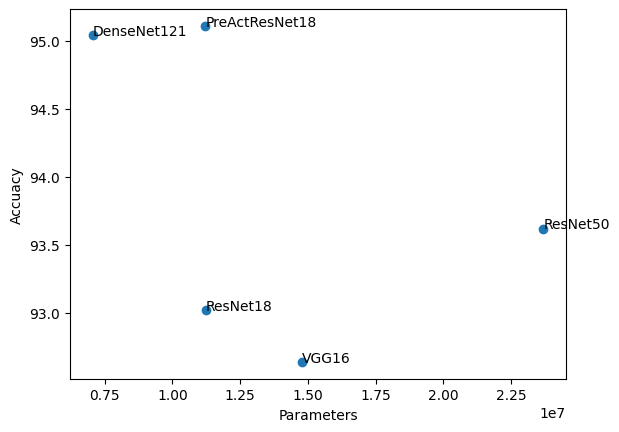

In [28]:
plot_acc_vs_params(model_acc, model_params)

In [ ]:
![Image](accuracy_vs_parameters_imagenet.png)

## Part 3: Save and reload your trained models


Pytorch has a [page](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) explaining how to save and load models. But here are a few additional details. 

You explored various architecture hyperparameters and saved your trained models. In order to load a model, you need to define the model in the same way that it was defined when training it. 

Let's assume your model definition during training had a single hyperparameter that you explored with various values.

In [ ]:
model = MySuperModel(hyperparam = hparam_currentvalue)

The following code enables you to save the currently trained model (his parameters, it is called a *state dictionary* in pytorch) as well as the current value `hparam_currentvalue` of the hyperparameter.


In [ ]:
state = {
        'net': model.state_dict(),
        'hyperparam': hparam_currentvalue
}

torch.save(state, 'mybestmodel.pth')

In order to reload this model, first we need to define it. This means we need to fetch the value of the hyperparameter before defining the model and loading the trained parameters. 


In [ ]:
# We load the dictionary
loaded_cpt = torch.load('mybestmodel.pth')

# Fetch the hyperparam value
hparam_bestvalue = loaded_cpt['hyperparam']

# Define the model 
model = MySuperModel(hyperparam = hparam_bestvalue)

# Finally we can load the state_dict in order to load the trained parameters 
model.load_state_dict(loaded_cpt['net'])

# If you use this model for inference (= no further training), you need to set it into eval mode
model.eval()

## Part 4 - Project

Prepare a presentation (10 minutes + 5 minutes question) with the following content : 
- Description of the chosen architecture
- Hyperparameter exploration strategy 
- Results on CIFAR10 subset, focusing on illustrating the **compromises between model size, training time and performance**

If you are ahead in time, you can perform similar experiments on the full CIFAR-10 and CIFAR-100, but be aware that each run (e.g. 350 epochs) might take as long as 3 hours.

**N.B. It is very important that you consider the models in the kuangliu repository, as they have been dimensioned for the CIFAR-10 dataset. Respective models taken from other sources may be have been optimized for other datasets and therefore not adapted (over or underparametrized) to CIFAR-10.**

Conducted simple experiment using 3 VGG models, and varying the learning rate hyperparmater by three orders of magnitude on each of the VGG models. 
- Disabled learning rate update scheduler.
- Trained for 5 ephochs using full CIFAR10 dataset, note I am using a validation set - not specified in lab but is best practice.
- Saved each model where there was an improvement over previous model (for same architecture).
- Used tensorboard for train/validation loss monitoring

As discussed in the lab notes above the "learning rate is a very important (if not the most important) hyperparameter" - and has a very large effect. VGG11 has best test accuracy, learning rate of 0.01 was best. Undertrained - more epochs for all models and learning rates  would improve accuracy. 

![Image](images/lab1_loss_lr.png)